# 序列模型
序列模型用来处理序列数据，比如不同时期的电影评分数据、一段音频或文本、不同时间的股票价格数据等,这些数据的特点是当前的数据跟过去的数据相关。
## 序列数据的建模：（隐变量）自回归模型
处理序列数据需要新的建模方式。为了简单起见，我们以股票价格（富时100指数）为例：

![近30年的富时100指数](./ftse100.png)

其中，用$x_t$表示价格，即在*时间步*（time step）
$t \in \mathbb{Z}^+$时，观察到的价格$x_t$。
请注意，$t$对于本文中的序列通常是离散的，并在整数或其子集上变化。
假设一个交易员想在$t$日的股市中表现良好，于是通过以下途径预测$x_t$：

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

即根据前$t-1$个数据点，预测第$t$个数据点。

为了实现这个预测，交易员可以使用之前介绍的回归模型，但有一个问题是：输入数据的数量，输入$x_{t-1}, \ldots, x_1$本身因$t$而异。也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加。而在前面的回归问题中，每个样本的输入特征维度是固定的，即输入数据的数量是统一的。因此需要一个近似方法来使这个计算变得容易处理。本章后面的大部分内容将围绕着如何有效估计$P(x_t \mid x_{t-1}, \ldots, x_1)$展开。简单地说，它归结为以下两种策略。

* 第一种策略，假设在现实情况下相当长的序列$x_{t-1}, \ldots, x_1$可能是不必要的，因此我们只需要满足某个长度为$\tau$的时间跨度，即使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$。当下获得的最直接的好处就是参数的数量总是不变的，至少在$t > \tau$时如此，这就使我们能够训练一个上面提及的深度网络。这种模型被称为*自回归模型*（autoregressive models），因为它们是对自己执行回归。只要这种是近似精确的，我们就说序列满足*马尔可夫条件*（Markov condition）。
* 第二种策略，如 :numref:`fig_sequence-model`所示，是保留一些对过去观测的总结$h_t$，并且同时更新预测$\hat{x}_t$和总结$h_t$。这就产生了基于$\hat{x}_{t} = P(x_{t} \mid h_{t})$估计$x_{t}$，以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。由于$h_t$从未被观测到，这类模型也被称为*隐变量自回归模型*（latent autoregressive models）。

![隐变量自回归模型](./sequence-model.svg)
:label:`fig_sequence-model`

## 一个例子：正弦函数的预测

首先我们生成一些数据：使用正弦函数和一些噪声来生成序列数据，时间步为1~1000.

In [19]:
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt

In [20]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

Text(0, 0.5, 'x')

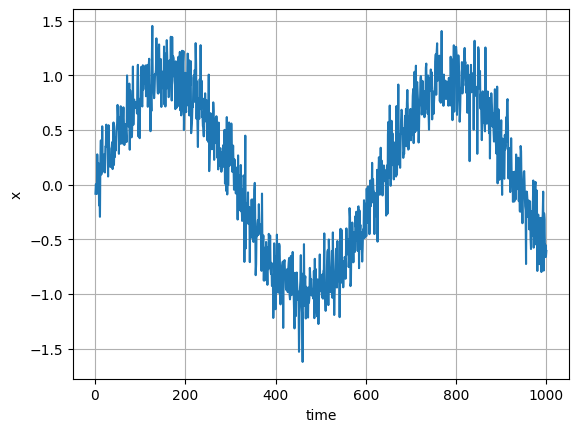

In [21]:
plt.plot(time, x)
plt.grid()
plt.xlabel('time')
plt.ylabel('x')

接下来，我们将这个序列转换为模型的特征-标签对，$y_t = x_t$和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。我们没有足够的历史记录来描述前$\tau$个数据样本。一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；另一个方法是用零填充序列。在这里，我们仅使用前600个“特征－标签”对进行训练。

In [22]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau: ].reshape(-1, 1)

In [23]:
features.shape

torch.Size([996, 4])

In [24]:
batch_size, n_train = 16, 600
train_iter = torch.utils.data.DataLoader(data.TensorDataset(features[:n_train], labels[:n_train]), 
                                        batch_size = batch_size,
                                        shuffle = True)
test_iter = torch.utils.data.DataLoader(data.TensorDataset(features[n_train:], labels[n_train:]), 
                                        batch_size = batch_size,
                                        shuffle = False)

接下来，我们定义一个简单的架构训练模型：一个拥有两个全连接层的多层感知机，relu激活函数和平方损失：

In [25]:
net = nn.Sequential(nn.Linear(4, 10),
                    nn.ReLU(),
                   nn.Linear(10, 1))

loss = nn.MSELoss()

训练模型：

In [26]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [27]:
num_epochs = 5
for epoch in range(num_epochs):
    for X, y in train_iter:
        optimizer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        optimizer.step()
    with torch.no_grad():
        loss_total = 0
        num_batches = 0
        for X, y in test_iter:
            l = loss(net(X), y)
            loss_total += l.item()
            num_batches += 1
    print(f'epoch {epoch + 1}', f'loss on test dataset:{loss_total / num_batches}')

epoch 1 loss on test dataset:0.3131545946002007
epoch 2 loss on test dataset:0.14856937035918236
epoch 3 loss on test dataset:0.07665487580001354
epoch 4 loss on test dataset:0.058129348382353785
epoch 5 loss on test dataset:0.055326983630657196


可以看出，模型在测试集上的性能是不错的。让我们直观地看看它的效果，首先是检查模型预测下一个时间步的能力，即单步预测：

In [28]:
onestep_preds = net(features)

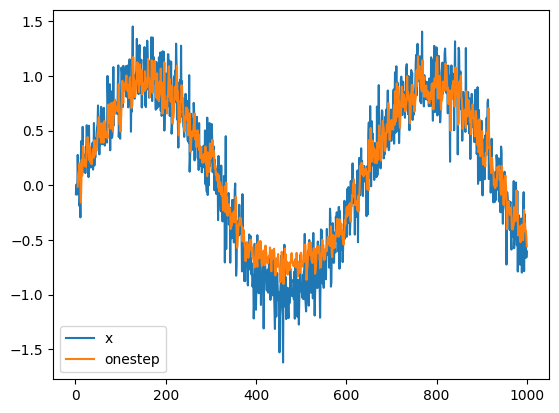

In [29]:
fig, ax = plt.subplots()
ax.plot(time, x.detach().numpy())
ax.plot(time[tau:], onestep_preds.detach().numpy())
ax.legend(['x', 'onestep'])

正如我们所料，单步预测效果不错。

通常，对于只到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$称为$k$*步预测*（$k$-step-ahead-prediction）。由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。让我们看看效果如何。

In [31]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

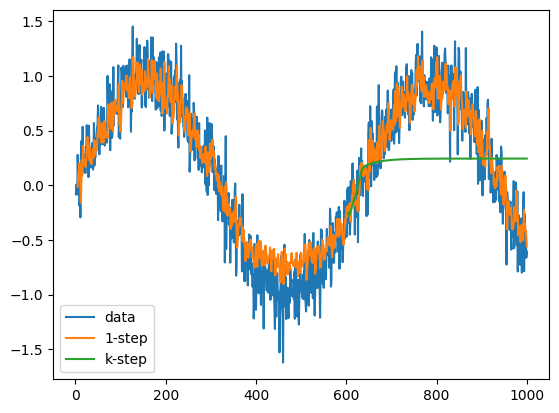

In [33]:
fig, ax = plt.subplots()
ax.plot(time, x.detach().numpy())
ax.plot(time[tau:], onestep_preds.detach().numpy())
ax.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy())
ax.legend(['data', '1-step','k-step'])

如上面的例子所示，绿线的预测显然并不理想。经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。为什么这个算法效果这么差呢？事实是由于错误的累积：假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。于是，步骤$2$的输入被扰动了$\epsilon_1$，结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，其中$c$为某个常数，后面的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。例如，未来$24$小时的天气预报往往相当准确，但超过这一点，精度就会迅速下降。

## 小结
* 对于序列数据有两种建模方法，分别是自回归模型和隐变量自回归模型
* 利用自回归模型对序列数据进行建模并执行多步预测时，误差会逐步累积，最终得到很差的准确度。